<img src="NotebookAddons/banner_notebook.jpg" width="100%" />

# Menyiapkan HyP3 InSAR Stack Untuk MintPy

**Author**: Gunawan Wisnu W; Institut Teknologi Sepuluh Nopember
 
Diambil dari [prep_hyp3_for_mintpy.ipynb](https://github.com/ASFHyP3/hyp3-docs) oleh Jiang Zhu; University of Alaska Fairbanks <p>
Notebook ini merupakan proses dalam menyiapkan data **_unwrapped interferograms stack_** sebagai input MintPy untuk analisis _displacement_ secara _time series_ 

Berikut adalah tahapan proses yang akan dijalankan:
    
1. Menggunakan [ASF Search Python package](https://docs.asf.alaska.edu/asf_search/basics/) untuk:
   - Pencarian produk SAR Sentinel-1 di katalog ASF  
   - Memilih _reference scene_ untuk membuat _baseline stack_
   - Memilih [short baseline subset (SBAS)](https://docs.asf.alaska.edu/vertex/sbas/) dari pasangan scene untuk pengolahan InSAR

2. Menggunakan [HyP3 Python SDK](https://hyp3-docs.asf.alaska.edu/using/sdk/) untuk:
   - Request produk **_On Demand InSAR_** dari ASF HyP3
   - Download produk InSAR ketika selesai diproses ASF HyP3

3. Menggunakan [GDAL](https://gdal.org/api/index.html#python-api) untuk menyiapkan produk InSAR yang terdownload untuk diproses lebih lanjut dengan [MintPy](https://mintpy.readthedocs.io/en/latest/)
  

## 1. Pengaturan Notebook

Pengaturan awal  yang diperlukan antara lain load library serta menentukan nilai parameter yang diperlukan. Notebook ini menggunakan widget untuk _user interaction_, untuk itu perlu juga load library pendukungnya. Pastikan menggunakan conda environment :**insar_analysis**  

In [7]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [8]:
import copy
from datetime import datetime, timedelta
import ipywidgets as widgets
from itertools import chain
import json
from pathlib import Path
import re
import requests
from tqdm import tqdm
from typing import Union

import numpy as np
from osgeo import gdal
import pyproj
from pyproj import Transformer
import pandas
import leafmap
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
from IPython.display import display, HTML, clear_output
from pathlib import Path

from dateutil.parser import parse as parse_date

import opensarlab_lib as asfn

from hyp3_sdk import Batch, HyP3

%matplotlib widget

In [3]:
#uncomment jika import leafmap gagal (belum terinstall library/package leafmap)
#!pip install leafmap
#!jupyter labextension install jupyter-leaflet

In [4]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/insar_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "insar_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "insar_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "insar_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

### 1.1. Membuat folder kerja (working directory)

In [5]:
while True:
    print(f"Current working directory: {Path.cwd()}")
    data_dir = Path(input(f"\nPlease enter the name of a directory in which to store your data for this analysis."))
    if data_dir == Path('.'):
        continue
    if data_dir.is_dir():
        contents = data_dir.glob('*')
        if len(list(contents)) > 0:
            choice = asfn.handle_old_data(data_dir)
            if choice == 1:
                if data_dir.exists():
                    shutil.rmtree(data_dir)
                data_dir.mkdir()
                break
            elif choice == 2:
                break
            else:
                clear_output()
                continue
        else:
            break
    else:
        data_dir.mkdir()
        break

Current working directory: /home/jovyan/Labs/Thesis



Please enter the name of a directory in which to store your data for this analysis. hyp3_look_10x2_23_ifgram



********************** WARNING! **********************
The directory hyp3_look_10x2_23_ifgram already exists and contains:
• S1AA_20220103T215940_20220115T215940_VVP012_INT40_G_ueF_DDFB
• S1AA_20220208T215939_20220220T215939_VVP012_INT40_G_ueF_B254
• full_scene.tif
• raster_stack.vrt
• S1AA_20220409T215939_20220421T215940_VVP012_INT40_G_ueF_0E98
• S1AA_20220115T215940_20220127T215939_VVP012_INT40_G_ueF_C603
• S1AA_20220328T215939_20220409T215939_VVP012_INT40_G_ueF_D47D
• S1AA_20220608T215943_20220620T215944_VVP012_INT40_G_ueF_0563
• S1AA_20220127T215939_20220208T215939_VVP012_INT40_G_ueF_9716
• S1AA_20220515T215941_20220527T215942_VVP012_INT40_G_ueF_0BF8
• S1AA_20220304T215938_20220316T215938_VVP012_INT40_G_ueF_0DC7
• S1AA_20220702T215944_20220714T215945_VVP012_INT40_G_ueF_DD9D
• .ipynb_checkpoints
• S1AA_20220527T215942_20220608T215943_VVP012_INT40_G_ueF_F4BB
• S1AA_20220316T215938_20220328T215939_VVP012_INT40_G_ueF_F387
• S1AA_20220620T215944_20220702T215944_VVP012_INT40_G_ueF_E875


Select option 1, 2, or 3.
 2


In [6]:
work_dir = Path.cwd()
data_dir = work_dir / str(data_dir)

## 2. Memilih pasangan scene untuk InSAR dengan ASF Search

- Gunakan [ASF Data Search /Vertex](https://search.asf.alaska.edu/) untuk membuat SBAS interferogram pairs
- Gunakan fasilitas ke On Demand Processing untuk membuat interferogram di ASF (Hyp3 Product)

## 3. Request On Demand InSAR products dari ASF HyP3

Gunakan [NASA Earthdata login](https://urs.earthdata.nasa.gov/) untuk mengakses [ASF HyP3](https://hyp3-docs.asf.alaska.edu/). Proses ini akan memakan waktu sekitar 1-2 jam karena menunggu proses pembuatan interferograms dari ASF Hyp3. Proses dapat dipantau melalui dengan 'hyp3.watch(jobs)' atau melihat di [ASF Data Search /Vertex](https://search.asf.alaska.edu/)

In [6]:
import asf_search as asf
import pandas as pd

import hyp3_sdk as sdk
hyp3 = sdk.HyP3(prompt=True)

NASA Earthdata Login username:  gunawan.wisnu@gmail.com
NASA Earthdata Login password:  ········


### 3.1. Download job On Demand Process


In [7]:
from tqdm.notebook import trange, tqdm

my_hyp3_info = hyp3.my_info()
active_projects = dict()

print("Checking all HyP3 projects for current INSAR_GAMMA jobs")
for project in tqdm(my_hyp3_info['job_names']):
    batch =sdk.Batch()
    batch = hyp3.find_jobs(name=project, job_type='INSAR_GAMMA').filter_jobs(running=False, include_expired=False)
    if len(batch) > 0:
        active_projects.update({batch.jobs[0].name: batch})

if len(active_projects) > 0:
    display(Markdown("<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>"))
    print('\nSelect a Project:')
    project_select = asfn.select_parameter(active_projects.keys())
    display(project_select)
else:
    print("Found no active projects containing InSAR products")

Checking all HyP3 projects for current INSAR_GAMMA jobs


  0%|          | 0/10 [00:00<?, ?it/s]

<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>


Select a Project:


RadioButtons(layout=Layout(min_width='800px'), options=('defo_2022', 'deformation_2022', 'look_10x2', 'look_10…

In [9]:
jobs = active_projects[project_select.value]
print(f"Ada {len(jobs)} products/files yang bisa didownload.")

Ada 23 products/files yang bisa didownload.


### 3.2. Download files, unzip dan delete the zip files

In [10]:
analysis_directory = Path.cwd()/(data_dir)
print(f"analysis_directory: {analysis_directory}")

#products_path = analysis_directory.joinpath('hyp3_insar_gamma')
products_path = analysis_directory
print(products_path)
if not products_path.is_dir():
    products_path.mkdir()

analysis_directory: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram
/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram


In [11]:
for i in range(len(jobs)):
    print(jobs[i].files[0]['filename'])

S1AA_20220912T215937_20221030T215938_VVP048_INT40_G_ueF_9330.zip
S1AA_20221111T215937_20221217T215936_VVP036_INT40_G_ueF_008D.zip
S1AA_20221217T215936_20221229T215935_VVP012_INT40_G_ueF_3155.zip
S1AA_20220103T215940_20220115T215940_VVP012_INT40_G_ueF_DDFB.zip
S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24.zip
S1AA_20220316T215938_20220328T215939_VVP012_INT40_G_ueF_F387.zip
S1AA_20220527T215942_20220608T215943_VVP012_INT40_G_ueF_F4BB.zip
S1AA_20220726T215935_20220807T215936_VVP012_INT40_G_ueF_5E2B.zip
S1AA_20220115T215940_20220127T215939_VVP012_INT40_G_ueF_C603.zip
S1AA_20220515T215941_20220527T215942_VVP012_INT40_G_ueF_0BF8.zip
S1AA_20220208T215939_20220220T215939_VVP012_INT40_G_ueF_B254.zip
S1AA_20220220T215939_20220304T215938_VVP012_INT40_G_ueF_96FA.zip
S1AA_20220702T215944_20220714T215945_VVP012_INT40_G_ueF_DD9D.zip
S1AA_20220127T215939_20220208T215939_VVP012_INT40_G_ueF_9716.zip
S1AA_20220831T215937_20220912T215937_VVP012_INT40_G_ueF_0513.zip
S1AA_20220608T215943_2022

In [14]:
print(f"\nProject: {jobs.jobs[0].name}")
    
project_zips = jobs.download_files(products_path)
for z in project_zips:
    asfn.asf_unzip(str(products_path), str(z))
    z.unlink()


Project: look_10x2_23


  0%|          | 0/23 [00:00<?, ?it/s]

S1AA_20220912T215937_20221030T215938_VVP048_INT40_G_ueF_9330.zip:   0%|          | 0/846177366 [00:00<?, ?it/s…

S1AA_20221111T215937_20221217T215936_VVP036_INT40_G_ueF_008D.zip:   0%|          | 0/844485405 [00:00<?, ?it/s…

S1AA_20221217T215936_20221229T215935_VVP012_INT40_G_ueF_3155.zip:   0%|          | 0/839705990 [00:00<?, ?it/s…

S1AA_20220103T215940_20220115T215940_VVP012_INT40_G_ueF_DDFB.zip:   0%|          | 0/821953326 [00:00<?, ?it/s…

S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24.zip:   0%|          | 0/524981901 [00:00<?, ?it/s…

S1AA_20220316T215938_20220328T215939_VVP012_INT40_G_ueF_F387.zip:   0%|          | 0/819964675 [00:00<?, ?it/s…

S1AA_20220527T215942_20220608T215943_VVP012_INT40_G_ueF_F4BB.zip:   0%|          | 0/821330525 [00:00<?, ?it/s…

S1AA_20220726T215935_20220807T215936_VVP012_INT40_G_ueF_5E2B.zip:   0%|          | 0/845262846 [00:00<?, ?it/s…

S1AA_20220115T215940_20220127T215939_VVP012_INT40_G_ueF_C603.zip:   0%|          | 0/817092914 [00:00<?, ?it/s…

S1AA_20220515T215941_20220527T215942_VVP012_INT40_G_ueF_0BF8.zip:   0%|          | 0/816875598 [00:00<?, ?it/s…

S1AA_20220208T215939_20220220T215939_VVP012_INT40_G_ueF_B254.zip:   0%|          | 0/820973102 [00:00<?, ?it/s…

S1AA_20220220T215939_20220304T215938_VVP012_INT40_G_ueF_96FA.zip:   0%|          | 0/820409143 [00:00<?, ?it/s…

S1AA_20220702T215944_20220714T215945_VVP012_INT40_G_ueF_DD9D.zip:   0%|          | 0/815239701 [00:00<?, ?it/s…

S1AA_20220127T215939_20220208T215939_VVP012_INT40_G_ueF_9716.zip:   0%|          | 0/818925529 [00:00<?, ?it/s…

S1AA_20220831T215937_20220912T215937_VVP012_INT40_G_ueF_0513.zip:   0%|          | 0/839871382 [00:00<?, ?it/s…

S1AA_20220608T215943_20220620T215944_VVP012_INT40_G_ueF_0563.zip:   0%|          | 0/819534697 [00:00<?, ?it/s…

S1AA_20220620T215944_20220702T215944_VVP012_INT40_G_ueF_E875.zip:   0%|          | 0/818668830 [00:00<?, ?it/s…

S1AA_20220807T215936_20220819T215936_VVP012_INT40_G_ueF_39CF.zip:   0%|          | 0/837548525 [00:00<?, ?it/s…

S1AA_20220409T215939_20220421T215940_VVP012_INT40_G_ueF_0E98.zip:   0%|          | 0/819002589 [00:00<?, ?it/s…

S1AA_20220328T215939_20220409T215939_VVP012_INT40_G_ueF_D47D.zip:   0%|          | 0/816513720 [00:00<?, ?it/s…

S1AA_20220702T220009_20220726T220000_VVP024_INT40_G_ueF_F7FE.zip:   0%|          | 0/526045827 [00:00<?, ?it/s…

S1AA_20220819T215936_20220831T215937_VVP012_INT40_G_ueF_DF55.zip:   0%|          | 0/838955292 [00:00<?, ?it/s…

S1AA_20220304T215938_20220316T215938_VVP012_INT40_G_ueF_0DC7.zip:   0%|          | 0/818814863 [00:00<?, ?it/s…

Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220912T215937_20221030T215938_VVP048_INT40_G_ueF_9330.zip
Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20221111T215937_20221217T215936_VVP036_INT40_G_ueF_008D.zip
Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20221217T215936_20221229T215935_VVP012_INT40_G_ueF_3155.zip
Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220103T215940_20220115T215940_VVP012_INT40_G_ueF_DDFB.zip
Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24.zip
Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220316T215938_20220328T215939_VVP012_INT40_G_ueF_F387.zip
Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220527T215942_20220608T215943_VVP012_INT40_G_ueF_F4BB.zip
Extracting: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220726T215935_20220807T215936_VVP012_INT40

### 3.3. Memastikan file DEM, azimuth, dan incidence angle terdapat di folder hasil dowload

In [15]:
dems = list(products_path.glob('*/*dem*.tif'))
az_angle_maps = list(products_path.glob('*/*lv_phi*.tif'))
inc_angle_maps = list(products_path.glob('*/*lv_theta*.tif'))

if len(dems) > 0:
    print("Success: Found at least 1 DEM.")
else:
    raise FileNotFoundError("Failed to find at least 1 DEM. \
    \nYou will not be able to successfully run a MintPy time-series unless you reorder your HyP3 project \
with DEMS or provide one from another source.")
    
if len(az_angle_maps) > 0:
    print("Success: Found at least 1 Azimuth Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Azimuth Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Look Vectors' option selected.")
    
if len(inc_angle_maps) > 0:
    print("Success: Found at least 1 Incidence Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Incidence Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Inc. Angle Map' option selected.")

Success: Found at least 1 DEM.
Success: Found at least 1 Azimuth Angle Map.
Success: Found at least 1 Incidence Angle Map.


### 3.4. Menghapus file yang tidak dibutuhkan
Tidak semua file yang ada pada folder hasil ekstrak produk hyp3 diperlukan, agar tidak membebani penyimpanan data file yang tidak digunakan bisa didelete

In [16]:
for pattern in ["xml","png","kmz","md.txt"]:
    unneeded_files = products_path.glob(f"*/*.{pattern}")
    for file in unneeded_files:
        file.unlink()

## 4. Subset Data

### 4.1. Merge scene dan Stacking raster

In [25]:
products_path

PosixPath('/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram')

In [26]:
amp = list(products_path.glob(f'*/*_amp.tif'))
merge_paths = ""

for pth in amp:
    merge_paths = f"{merge_paths} {pth}"

full_scene = products_path/"full_scene.tif"
if full_scene.exists():
    full_scene.unlink()
gdal_command = f"gdal_merge.py -o {full_scene} {merge_paths}"
!{gdal_command}

image_file = f"{products_path}/raster_stack.vrt"
!gdalbuildvrt -separate $image_file -overwrite $full_scene
img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

#aoi = asfn.AOI_Selector(rasterstack, 7.5, 7.5)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


### 4.2. Membuat AOI untuk clip data

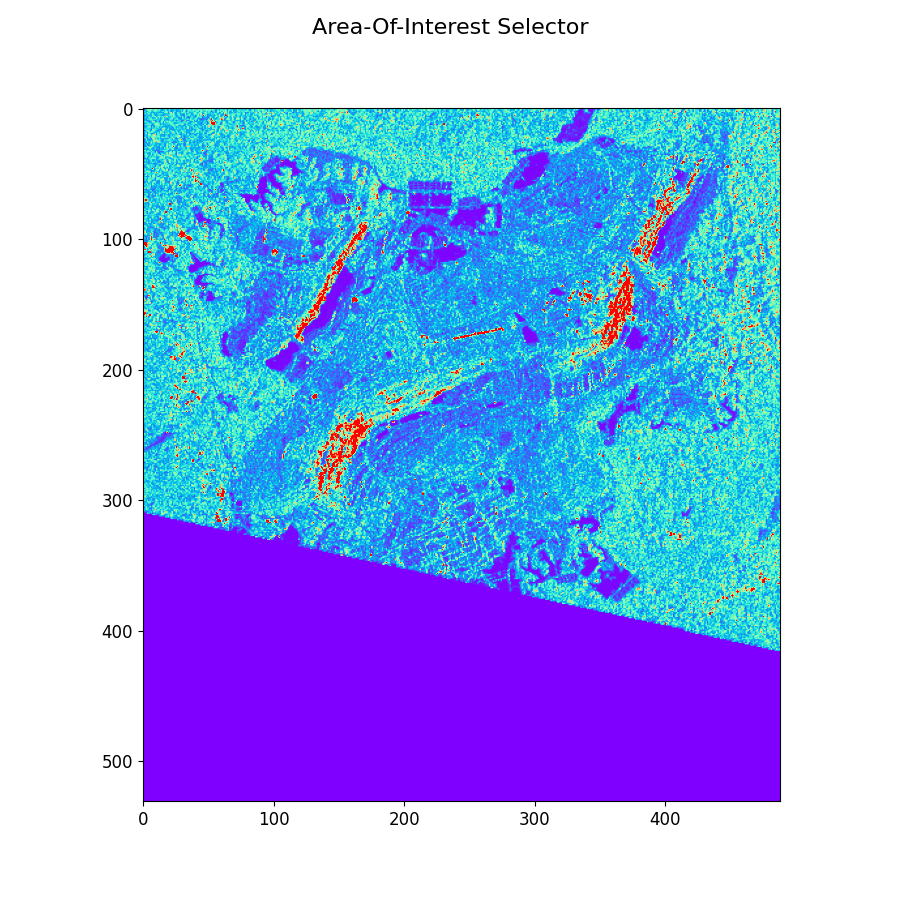

In [27]:
aoi=asfn.AOI_Selector(rasterstack, 9, 9)
#!pip show matplotlib
#!pip install -U matplotlib

**Convert the AOI plot's x,y values to georaphic coordinates:** 

In [19]:
geotrans = img.GetGeoTransform()

def geolocation(x, y, geotrans):
    return [geotrans[0]+x*geotrans[1], geotrans[3]+y*geotrans[5]]

try:
    ul = geolocation(aoi.x1, aoi.y1, geotrans)
    lr = geolocation(aoi.x2, aoi.y2, geotrans)
    print(f"AOI Corner Coordinates:")
    print(f"upper left corner: {ul}")
    print(f"lower right corner: {lr}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error may occur if an AOI was not selected.</text>'))
    display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))

AOI Corner Coordinates:
upper left corner: [325950.33046323585, 9765251.643658107]
lower right corner: [345527.8351651099, 9744071.70974576]


**Crop the stack to the AOI and reproject to lat-lon:**

In [20]:
fnames = list(products_path.glob('*/*.tif'))
fnames.sort()

for i, fname in enumerate(fnames):
    clip = fname.parent/f"{fname.stem}_clip.tif"
    gdal.SetConfigOption('CHECK_DISK_FREE_SPACE','FALSE')
    gdal.Translate(destName=str(clip), srcDS=str(fname), projWin=[ul[0], ul[1], lr[0], lr[1]])
    gdal.Warp(str(clip), str(clip), dstSRS='EPSG:4326', dstNodata=0)
    fname.unlink() 

**Remove any subset scenes containing no data:**

In [21]:
fnames = list(products_path.glob('*/*.tif*'))
fnames = [str(f) for f in fnames]
fnames.sort()

removed = []
for f in fnames:
    if not "dem" in str(f):
        raster = gdal.Open(f)
        if raster:
            band = raster.ReadAsArray()
            if np.count_nonzero(band) < 1:
                Path(f).unlink()
                removed.append(f)

if len(removed) == 0:
    print("No Geotiffs were removed")
else:
    print(f"{len(removed)} GeoTiffs removed:")
    for f in removed:
        print(f)

48 GeoTiffs removed:
/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24_amp_clip.tif
/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24_corr_clip.tif
/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24_lv_phi_clip.tif
/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24_lv_theta_clip.tif
/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24/S1AA_20220714T215945_20220726T215935_VVP012_INT40_G_ueF_5B24_unw_phase_clip.tif
/home/jovyan/Labs/Thesis/hyp3_look_10x2

## Reference Materials

- Tao, Q., Gao, T., Hu, L., & Wang, Z. (2018). Optimal selection and application analysis of multi-temporal differential interferogram series in StaMPS-based SBAS InSAR. European Journal of Remote Sensing, 51(1), 1070–1086. https://doi.org/10.1080/22797254.2018.1542977
 
